In [1]:
from DBQuerier import DBQuerier

import os
import pandas as pd
import numpy as np
import ast

fft_interval = 5.13980000
from scipy import signal

import datetime


In [2]:
querier = DBQuerier('db18','MMM-EMCO-E350')

In [3]:
def get_cutting_fft(startTime,endTime):
    # Create a pivot table for the controller data based on 
    # Whether this is the warmup program and the spindle speed
    query = """
        select * from 
        (select
            dateTime,
            sum(WattageS) as WattageS,
            sum(rotaryVelocityS_Commanded) as rotaryVelocityS_Commanded

        from
            (select
                db18.Controller.*,
                case when dataItemId = "WattageS" then db18.Controller.value end as WattageS,
                case when dataItemId = "rotaryVelocityS_Commanded" then db18.Controller.value end as rotaryVelocityS_Commanded

              from db18.Controller 
              where assetId = 'MMM-EMCO-E350') as t
          group by dateTime asc) as v

        where rotaryVelocityS_Commanded = 4584
        and WattageS > 1000
        and dateTime between '""" + startTime + """' and '""" + endTime + """';"""
    
    # Query database
    cursor = querier.execute_query(query)
    data = cursor.fetchall()

    # Parse data into numpy arrays based on columns
    dateTime = np.array([[data[i][0] for i in range(len(data))]]).T
    WattageS = np.array([[data[i][1] for i in range(len(data))]]).T
    rotaryVelocityS_Commanded = np.array([[data[i][2] for i in range(len(data))]]).T

    # Create pandas dataframe and save as csv
    columns = ['dateTime','WattageS','rotaryVelocityS_Commanded']
    values = np.hstack((dateTime,WattageS,rotaryVelocityS_Commanded))
    featuresDF = pd.DataFrame(data=values,columns=columns)
    featuresDF.to_csv('controller_warmup.csv')
    
    # Find ranges where we are receiving continuous data. This indicates that we are running
    # the warmup program continuously. We can use these ranges to search for vibration measurements
    featuresDF['dateTime'] = pd.to_datetime(featuresDF['dateTime'])
    featuresDF['time_diff'] = featuresDF.dateTime.diff()
    featuresDF['value_grp'] = ((featuresDF.time_diff > datetime.timedelta(seconds=1))).astype('int').cumsum()

    # Create a dataframe with the bounds on the dates and indexes
    Id_bounds_DF = pd.DataFrame({'BeginDate' : featuresDF.groupby('value_grp').dateTime.first(), 
                  'EndDate' : featuresDF.groupby('value_grp').dateTime.last(),
                         }).reset_index(drop=True)

    between_str = ''
    for i in range(Id_bounds_DF.shape[0]):
        between_str += "(FFT.dateTime between '" + str(Id_bounds_DF['BeginDate'][i]) + "' and '" + str(Id_bounds_DF['EndDate'][i])
        if i < Id_bounds_DF.shape[0] - 1:
            between_str += "') or "
        else:
            between_str += "')"
            
    query = """SELECT FFT.dateTime as dateTime,FFT.values,RMS.values as rmsVals,
    VibrationSkewness.values as skewVals,VibrationKurtosis.values as kurtVals,
    FFT.frequencyInterval,Vibration.values as vibVals FROM db18.FFT 
    inner join db18.RMS on db18.RMS.dateTime = db18.FFT.dateTime
    inner join db18.VibrationSkewness on db18.VibrationSkewness.dateTime = db18.FFT.dateTime
    inner join db18.VibrationKurtosis on db18.VibrationKurtosis.dateTime = db18.FFT.dateTime
    inner join db18.Vibration on db18.Vibration.dateTime = db18.FFT.dateTime
    where (""" + between_str + """)
    order by FFT.dateTime asc;"""
    
    cursor = querier.execute_query(query)
    data = cursor.fetchall()
    
    dateTime = np.array([[data[i][0] for i in range(len(data))]]).T
    fftVals = np.array([np.array(ast.literal_eval(data[i][1])) for i in range(len(data))])
    rmsVals = np.array([data[i][2] for i in range(len(data))])
    skewVals = np.array([data[i][3] for i in range(len(data))])
    kurtVals = np.array([data[i][4] for i in range(len(data))])
    
    frequencyInterval = [data[i][5] for i in range(len(data))]
    frequencyInterval = float(frequencyInterval[0])
    vibVals = np.array([np.array(ast.literal_eval(data[i][6])) for i in range(len(data))])
    
    
    return dateTime,fftVals,frequencyInterval,WattageS,rmsVals,skewVals,kurtVals,vibVals
        

In [4]:
nominal_dateTime,nominal_fftVals,frequencyInterval,nominal_power,nominal_rms,nominal_skew,nominal_kurt,nominal_vib = get_cutting_fft('2020-03-10 19:29:42','2020-03-10 19:32:00')

In [5]:
anominal_dateTime,anominal_fftVals,frequencyInterval,anominal_power,anominal_rms,anominal_skew,anominal_kurt,anominal_vib = get_cutting_fft('2020-03-10 19:48:18','2020-03-10 19:51:02')

In [8]:
responses = np.vstack((np.mean(nominal_fftVals,axis=0),np.mean(anominal_fftVals,axis=0)))[:,1:]
frequencies = np.arange(-0.0,10000,frequencyInterval)
start = 0
end = 512

np.save('data/Emco_Nominal_vs_Anomalous_FFT.npy',responses[:,start:end])
np.save('data/frequencies.npy',frequencies[start:end])
np.save('data/nominal_power.npy',nominal_power)
np.save('data/anomalous_power.npy',anominal_power)

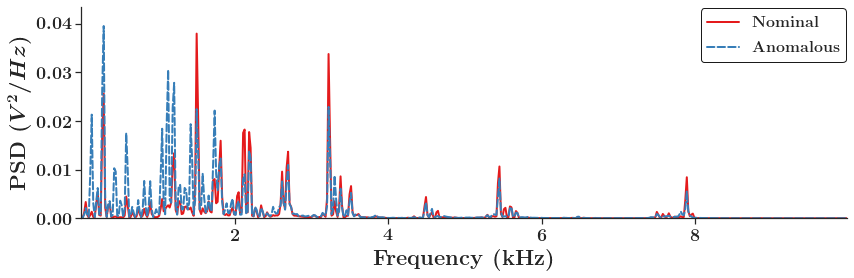

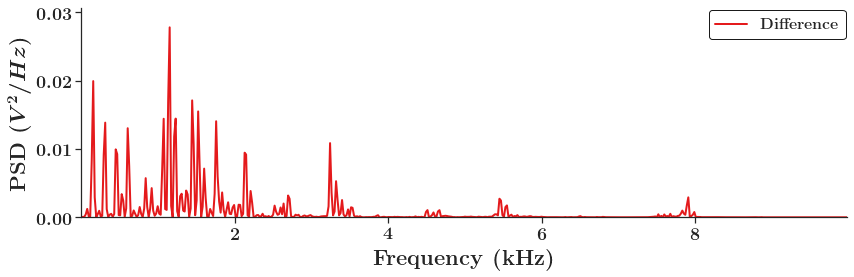

In [9]:
start = 0
end = 512

frequencies = np.arange(-0.0,10000,frequencyInterval)
# combine the responses and labels to put on our 2D plot
labels = [r'Nominal','Anomalous']


# Create a 2D plot
genplt.generate_plot(frequencies[start:end]/1000, # X - coordinate on the plot
              responses[:,start:end],# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (kHz)',# X - axis label
              r'PSD ($V^2 / Hz$)',   # Y - axis label
              filename='Emco_Nominal_vs_Anomalous_FFT',   # Plot filename
              folder='Figures',    # Specify the folder where the filename will be saved
              num_col=1,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='png'
             )


In [9]:
nominal_fftVals.shape

(21, 513)

In [10]:
diff = np.abs(np.mean(nominal_fftVals,axis=0) - np.mean(anominal_fftVals,axis=0))
frequencies[np.argmax(diff)]

1152.34375

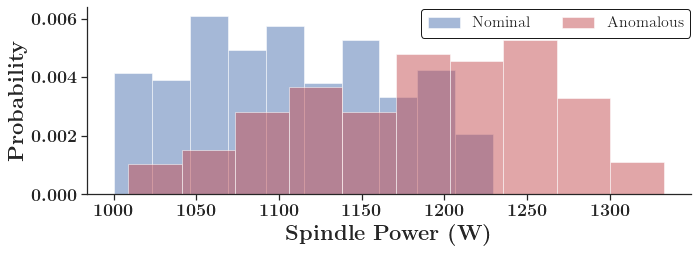

In [11]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(nominal_power, 10, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(anominal_power, 10, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Spindle Power (W)}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('Figures/Spindle_Load_Anomalous_Compare.png',transparent=True)     
plt.show()


In [12]:
np.save('data/nominal_rms.npy',nominal_rms)
np.save('data/anomalous_rms.npy',anominal_rms)

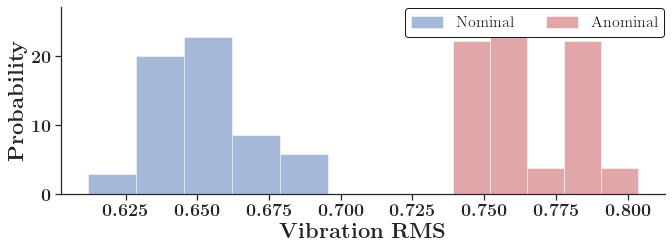

In [14]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(nominal_rms, 5, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(anominal_rms, 5, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Vibration RMS}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('Figures/RMS_Anomalous_Compare.png',transparent=True)  
plt.show()
